# Day 2: Lead Time Time Series Investigation (Normalised)

This notebook does nearly the same thing as 02_DifferentLeadTimes_TimeSeries.ipynb, but with all physical TRB indices converted to z-scores respective to each DCPP model or observation. z-score is calculated by subtracting the DCPP model or observation overall mean from its time series, then dividing by its time series standard deviation.

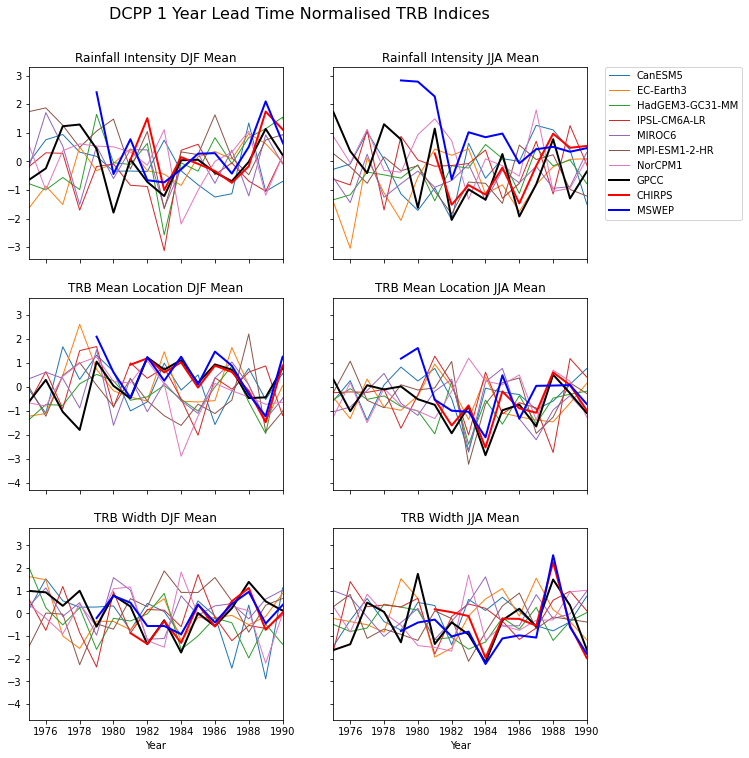

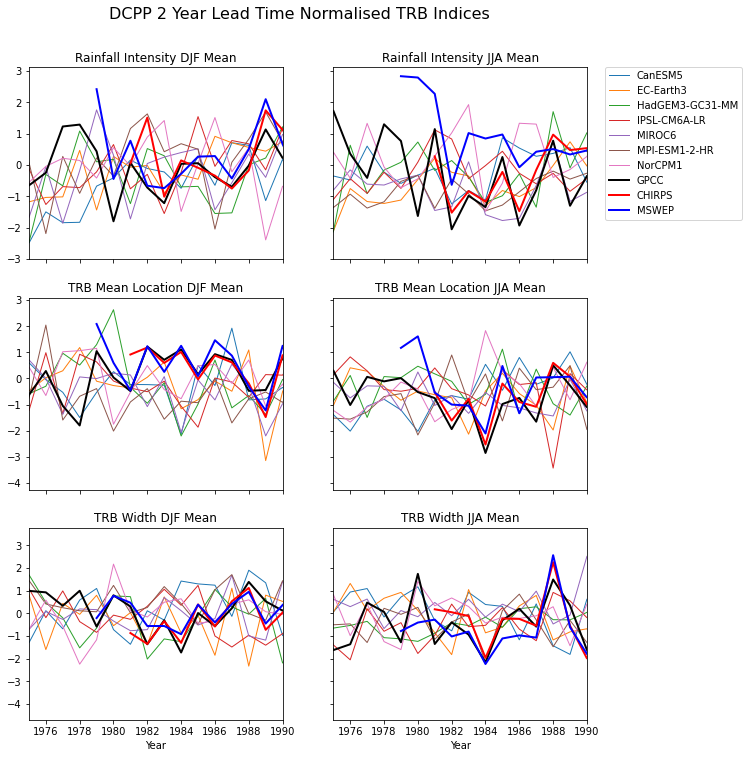

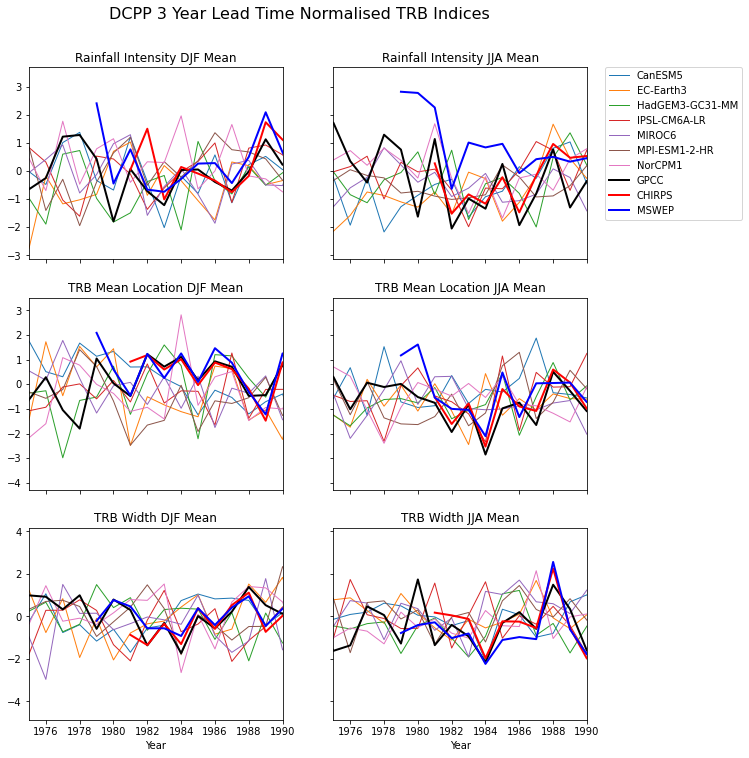

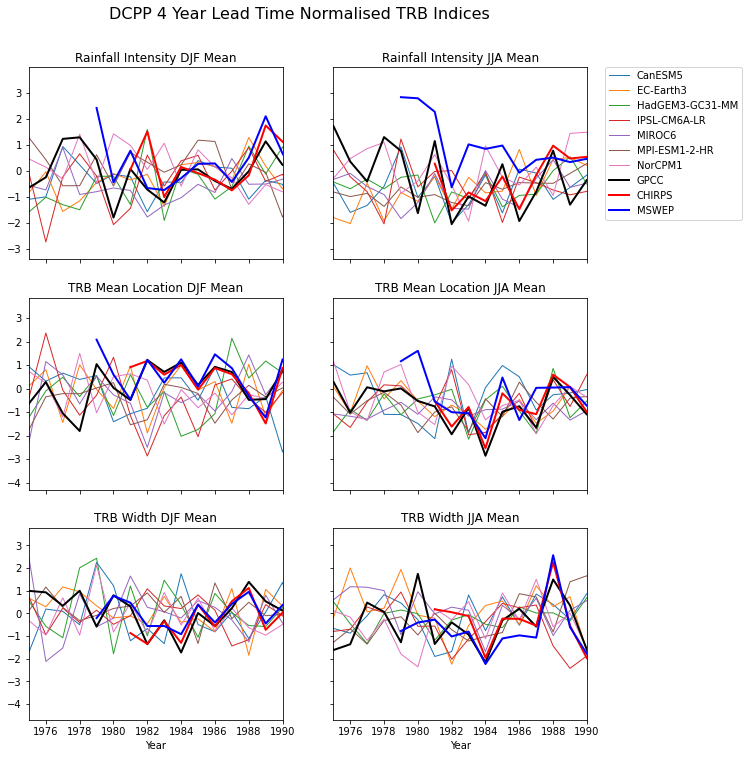

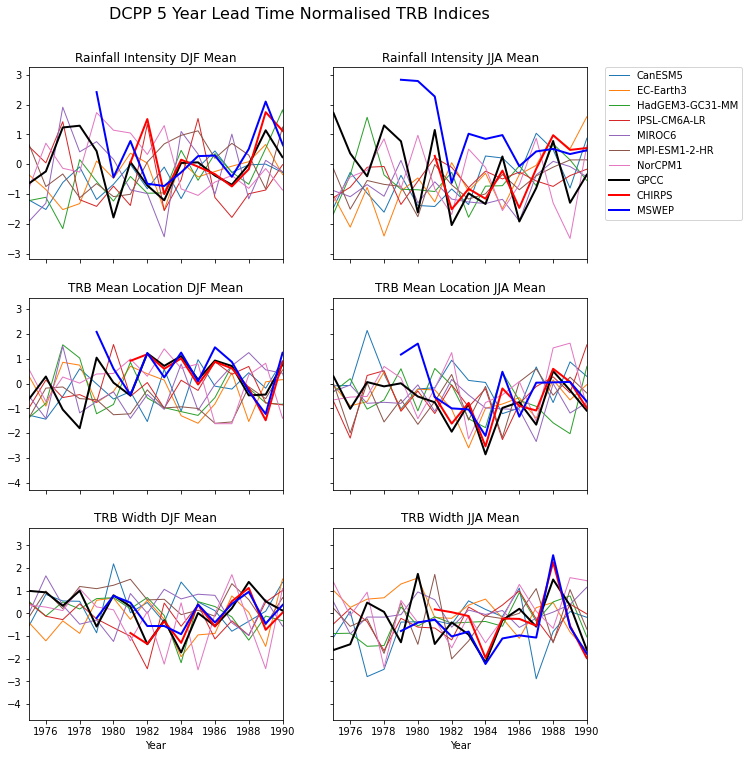

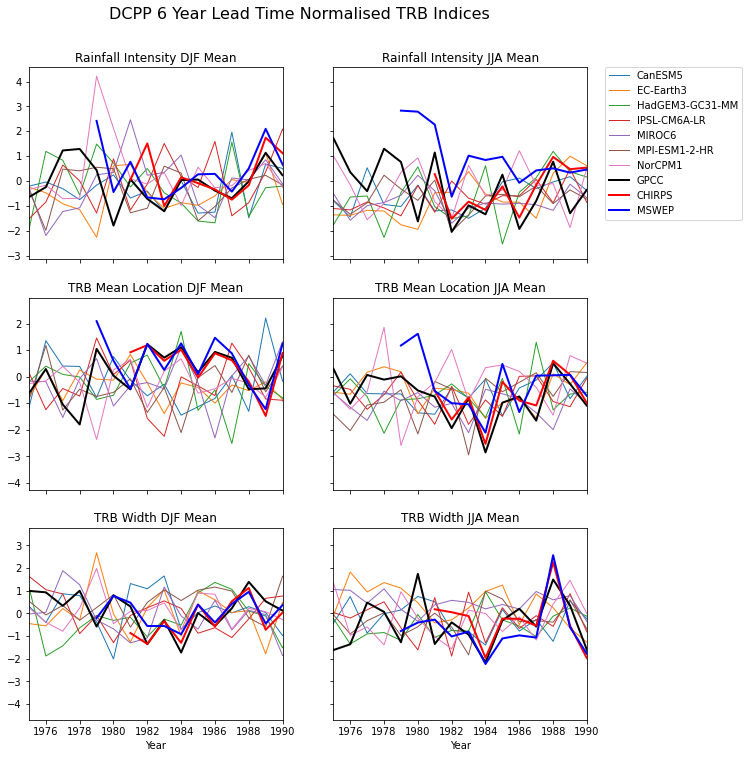

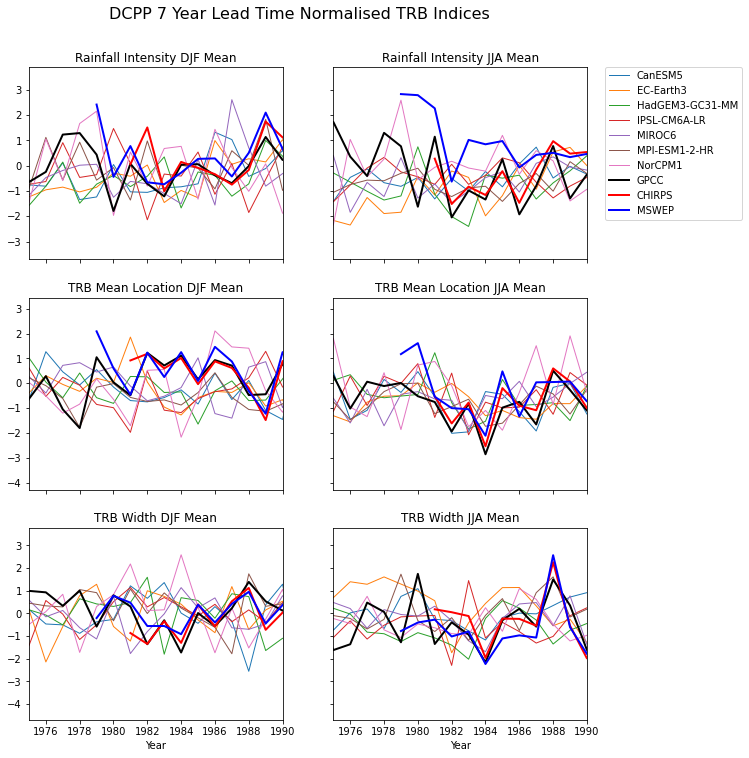

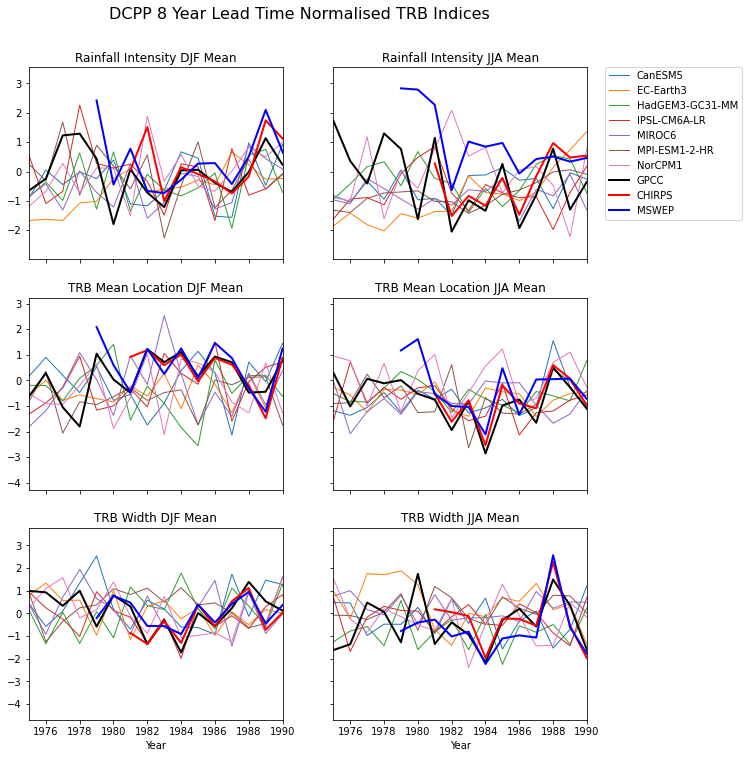

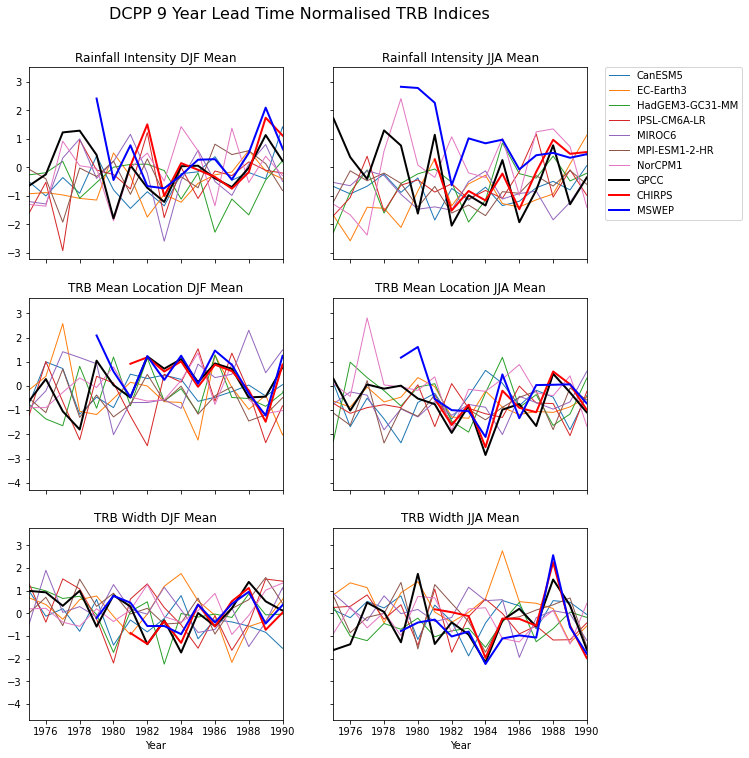

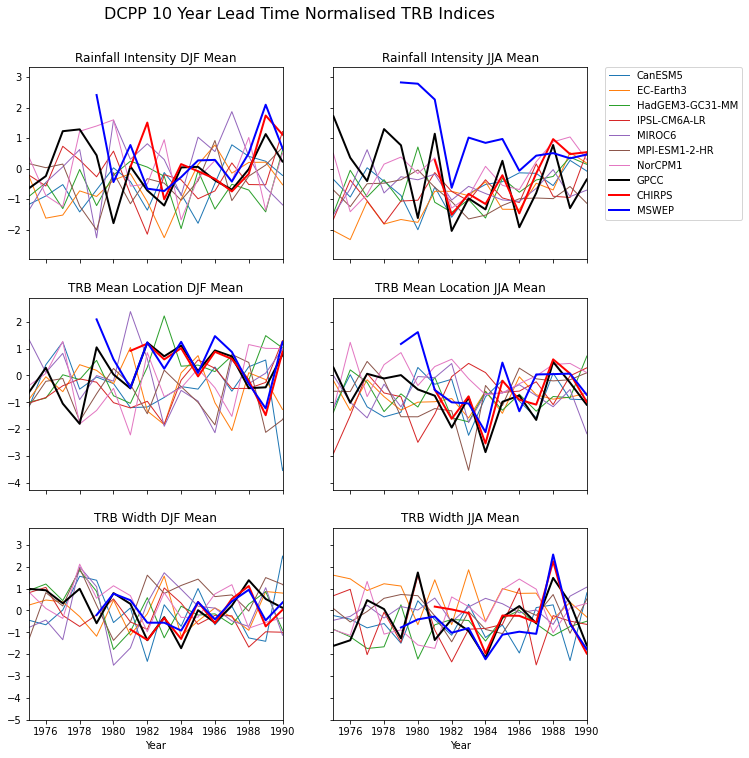

In [12]:
import numpy as np
import xarray as xr
import glob as glob
import matplotlib.pyplot as plt


model_namelist = ['CanESM5', 'EC-Earth3', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'NorCPM1']
obs_namelist = ['GPCC', 'CHIRPS', 'MSWEP']
obs_colourlist = ['black', 'red', 'blue']

dcpp_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/DCPP/TRBindices'
obs_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/obs/TRBindices'

lead_time_years = np.arange(1,11,1)
lead_time_year_filenames = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

for jdx, lead_time_year in enumerate(lead_time_years):
    fig, axs = plt.subplots(3, 2, figsize=(10,12), sharey='row', sharex=True)
    
    obs_zscore_list_djf = list()
    obs_zscore_list_jja = list()
    for obs_name in obs_namelist:
        obs_filelist = glob.glob(obs_trbindices_directory+'/'+obs_name+'/*.nc')
        obs_filelist.sort()

        # Selection conditions
        obs_data = xr.open_mfdataset(obs_filelist)
        obs_data_indices = obs_data.gaussian_params
        is_djf = (obs_data_indices['time'].dt.season == 'DJF')
        is_jja = (obs_data_indices['time'].dt.season == 'JJA')
        obs_data_djf = obs_data_indices.isel(time=is_djf)
        obs_data_jja = obs_data_indices.isel(time=is_jja)

        obs_data_mean_djf = obs_data_djf.groupby('time.year').mean('time')
        obs_data_mean_djf_1960_2019 = obs_data_mean_djf.sel(year=slice(1960,2019))
        obs_data_mean_djf_1960_2019_overallmean = obs_data_mean_djf_1960_2019.mean(dim='year')
        obs_data_mean_djf_1960_2019_overallstdev = obs_data_mean_djf_1960_2019.std(dim='year', ddof=1)
        obs_data_mean_djf_1960_2019_zscores = (obs_data_mean_djf_1960_2019 - obs_data_mean_djf_1960_2019_overallmean)/obs_data_mean_djf_1960_2019_overallstdev
        obs_zscore_list_djf.append(obs_data_mean_djf_1960_2019_zscores)

        obs_data_mean_jja = obs_data_jja.groupby('time.year').mean('time')
        obs_data_mean_jja_1960_2019 = obs_data_mean_jja.sel(year=slice(1960,2019))
        obs_data_mean_jja_1960_2019_overallmean = obs_data_mean_jja_1960_2019.mean(dim='year')
        obs_data_mean_jja_1960_2019_overallstdev = obs_data_mean_jja_1960_2019.std(dim='year', ddof=1)
        obs_data_mean_jja_1960_2019_zscores = (obs_data_mean_jja_1960_2019 - obs_data_mean_jja_1960_2019_overallmean)/obs_data_mean_jja_1960_2019_overallstdev
        obs_zscore_list_jja.append(obs_data_mean_jja_1960_2019_zscores)
        
    for model_name in model_namelist:
        model_filelist = glob.glob(dcpp_trbindices_directory+'/'+model_name+'/*.nc')
        model_filelist.sort()

        # model_list = list()
        model_ensembles_all_djf = list()
        model_ensembles_all_jja = list()
        for model_file in model_filelist:
            model_dataset = xr.open_dataset(model_file)

            # Selection conditions
            is_djf = (model_dataset['time'].dt.season == 'DJF')
            is_jja = (model_dataset['time'].dt.season == 'JJA')


            model_ensemble_mean = model_dataset.gaussian_params.mean(dim='ensemble')
            model_ensemble_mean_djf = model_ensemble_mean.isel(time=is_djf)
            model_ensemble_mean_djf = model_ensemble_mean_djf.groupby('time.year').mean('time').isel(year=lead_time_year-1)
            model_ensembles_all_djf.append(model_ensemble_mean_djf)

            model_ensemble_mean_jja = model_ensemble_mean.isel(time=is_jja)
            model_ensemble_mean_jja = model_ensemble_mean_jja.groupby('time.year').mean('time').isel(year=lead_time_year-1)
            model_ensembles_all_jja.append(model_ensemble_mean_jja)

        # Calculates z-score
        lead_time_time_series_djf = xr.concat(model_ensembles_all_djf, dim='year')
        lead_time_time_series_djf_overallmean = lead_time_time_series_djf.mean(dim='year')
        lead_time_time_series_djf_stdev = lead_time_time_series_djf.std(dim='year', ddof=1)
        lead_time_time_series_djf_zscore = (lead_time_time_series_djf - lead_time_time_series_djf_overallmean) / lead_time_time_series_djf_stdev

        lead_time_time_series_jja = xr.concat(model_ensembles_all_jja, dim='year')
        lead_time_time_series_jja_overallmean = lead_time_time_series_jja.mean(dim='year')
        lead_time_time_series_jja_stdev = lead_time_time_series_jja.std(dim='year', ddof=1)
        lead_time_time_series_jja_zscore = (lead_time_time_series_jja - lead_time_time_series_jja_overallmean) / lead_time_time_series_jja_stdev

        axs[0,0].plot(lead_time_time_series_djf.year, lead_time_time_series_djf_zscore.sel(popt='amplitude'), label=model_name, linewidth=1.0)
        axs[1,0].plot(lead_time_time_series_djf.year, lead_time_time_series_djf_zscore.sel(popt='mean'), label=model_name, linewidth=1.0)
        axs[2,0].plot(lead_time_time_series_djf.year, lead_time_time_series_djf_zscore.sel(popt='width'), label=model_name, linewidth=1.0)
        axs[0,1].plot(lead_time_time_series_jja.year, lead_time_time_series_jja_zscore.sel(popt='amplitude'), label=model_name, linewidth=1.0)
        axs[1,1].plot(lead_time_time_series_jja.year, lead_time_time_series_jja_zscore.sel(popt='mean'), label=model_name, linewidth=1.0)
        axs[2,1].plot(lead_time_time_series_jja.year, lead_time_time_series_jja_zscore.sel(popt='width'), label=model_name, linewidth=1.0)

    for idx, obs_result in enumerate(obs_zscore_list_djf):
        axs[0,0].plot(obs_zscore_list_djf[idx].year, obs_zscore_list_djf[idx][:,0], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)
        axs[1,0].plot(obs_zscore_list_djf[idx].year, obs_zscore_list_djf[idx][:,1], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)
        axs[2,0].plot(obs_zscore_list_djf[idx].year, obs_zscore_list_djf[idx][:,2], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)
        axs[0,1].plot(obs_zscore_list_jja[idx].year, obs_zscore_list_jja[idx][:,0], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)
        axs[1,1].plot(obs_zscore_list_jja[idx].year, obs_zscore_list_jja[idx][:,1], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)
        axs[2,1].plot(obs_zscore_list_jja[idx].year, obs_zscore_list_jja[idx][:,2], 
                      label=obs_namelist[idx], color=obs_colourlist[idx], linewidth=2.0)

    axs[0,1].legend(bbox_to_anchor=(1.05, 1.03), loc='upper left')

    axs[0,0].set_title('Rainfall Intensity DJF Mean')
    axs[1,0].set_title(r'TRB Mean Location DJF Mean')
    axs[2,0].set_title(r'TRB Width DJF Mean')
    axs[0,1].set_title('Rainfall Intensity JJA Mean')
    axs[1,1].set_title(r'TRB Mean Location JJA Mean')
    axs[2,1].set_title(r'TRB Width JJA Mean')
    axs[2,0].set_xlabel('Year')
    axs[2,1].set_xlabel('Year')

    # Use lines below to plot a certain time frame
    year_lim = [1975, 1990]
    axs[0,0].set_xlim(year_lim)

    fig.suptitle(f'DCPP {lead_time_year} Year Lead Time Normalised TRB Indices', fontsize=16, y=0.95)

#     plt.show()
    plt.savefig(f'plots/03_leadtime_analysis_normed/subgroup3_leadtime_zscore_bigsahel_{lead_time_year_filenames[jdx]}.pdf', bbox_inches='tight')